# Capstone: Eye for Blind

**Problem statement:** In this capstone project, you need to create a deep learning model which can explain the contents of an image in the form of speech through caption generation with an attention mechanism on Flickr8K dataset. This kind of model is a use-case for blind people so that they can understand any image with the help of speech. The caption generated through a CNN-RNN model will be converted to speech using a text to speech library. 

 

This problem statement is an application of both deep learning and natural language processing. The features of an image will be extracted by a CNN-based encoder and this will be decoded by an RNN model.

### 0. Import necessary libraries 

In [2]:
!pip install gtts

You should consider upgrading via the '/usr/bin/python -m pip install --upgrade pip' command.


In [3]:
# import libraries

import pandas as pd
import glob
import re
import imageio.v3 as iio
import matplotlib.pyplot as plt
import re
from collections import Counter
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.applications.inception_v3 import preprocess_input
from tqdm import tqdm
import tensorflow as tf
import numpy as np
from sklearn.model_selection import train_test_split
import time
from nltk.translate.bleu_score import sentence_bleu
from gtts import gTTS
import os
from IPython import display

### 1. Dataset loading and understanding

In [4]:
## define constants

IMAGE_PATH = 'datasets/flickr/Images'
CAPTIONS_PATH = 'datasets/flickr/captions.txt'
BATCH_SIZE = 256
IMG_SHAPE = (299, 299)

In [5]:
# load images

all_imgs = glob.glob(IMAGE_PATH + '/*.jpg',recursive=True)
print("The total images present in the dataset: {}".format(len(all_imgs)))

The total images present in the dataset: 8091


In [6]:
captions = pd.read_csv(CAPTIONS_PATH)
captions.head()

,image,caption
0,1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set o...
1,1000268201_693b08cb0e.jpg,A girl going into a wooden building .
2,1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .
3,1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playh...
4,1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a woo...


In [7]:
# utillity to read captions

def load_captions():
    doc = pd.read_csv(CAPTIONS_PATH)
    all_img_id = list(doc['image']) #store all the image id here
    all_img_vector = [f'{IMAGE_PATH}/{id}' for id in all_img_id] #store all the image path here
    annotations = list(doc['caption']) #store all the captions here
    annotations = [annot.rstrip('\n.') for annot in annotations]
        
    return all_img_id, all_img_vector, annotations

In [8]:
# create a dataframe which summarizes the image, path & captions as a dataframe

all_img_id, all_img_vector, annotations = load_captions()
df = pd.DataFrame(list(zip(all_img_id, all_img_vector,annotations)),columns =['Id','Path', 'Captions'])
print(df.shape)
df.head()

(40455, 3)


,Id,Path,Captions
0,1000268201_693b08cb0e.jpg,datasets/flickr/Images/1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set o...
1,1000268201_693b08cb0e.jpg,datasets/flickr/Images/1000268201_693b08cb0e.jpg,A girl going into a wooden building
2,1000268201_693b08cb0e.jpg,datasets/flickr/Images/1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse
3,1000268201_693b08cb0e.jpg,datasets/flickr/Images/1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playh...
4,1000268201_693b08cb0e.jpg,datasets/flickr/Images/1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a woo...


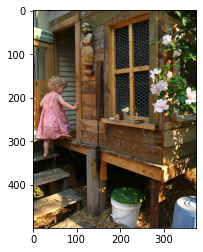

1. A child in a pink dress is climbing up a set of stairs in an entry way 
2. A girl going into a wooden building 
3. A little girl climbing into a wooden playhouse 
4. A little girl climbing the stairs to her playhouse 
5. A little girl in a pink dress going into a wooden cabin 
------------------------------------------------------------------------------------------------------------------------------------------------------


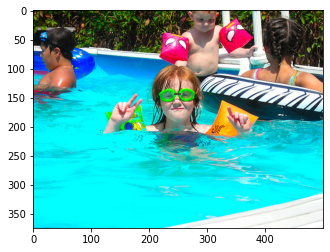

1. A girl in a pool wearing goggles and surrounded by other children
2. A girl in green goggles in a pool with three other children 
3. A red haired girl making a peace sign is wearing neon green glasses and floaties and playing in the pool with other kids 
4. A red-headed girl offers the peace sign as she swims in the pool with floaties 
5. A young girl with goggles and floaties poses for the camera as she plays in a pool 
------------------------------------------------------------------------------------------------------------------------------------------------------


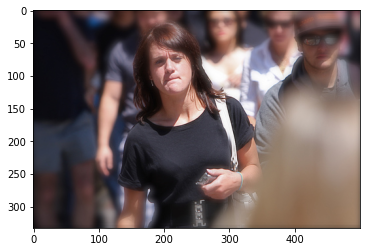

1. A woman in a black-shirt is walking holding a silver cellphone 
2. A woman in a black shirt walking down the street
3. A woman wearing a black shirt walks among a crowd in a city 
4. Brunette woman in black walking through blurred crowd 
5. Lady walking and squinting from the sun in a large group of people 
------------------------------------------------------------------------------------------------------------------------------------------------------


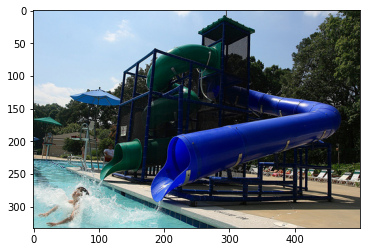

1. A boy splashes into a pool , ejected from a water slide 
2. A boy stands in the pool at the bottom of a blue water slide 
3. A child makes a splash in the pool as he emerges from the water chute 
4. A girl splashes in the water near a big blue water slide 
5. One blue and one green water slide 
------------------------------------------------------------------------------------------------------------------------------------------------------


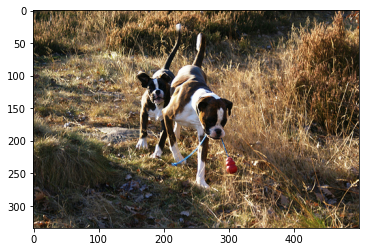

1. Two dogs are walking on a rugged path , one with a blue rope tied to a red object in its mouth 
2. Two dogs play in a grassy area with a red and blue toy 
3. Two dogs playing keep-away with red toy on blue string 
4. Two dogs play with a red plastic toy in the tall grass 
5. Two dogs walking through nature 
------------------------------------------------------------------------------------------------------------------------------------------------------


In [9]:
# visualise the images and their captions

random_ids = ['1000268201_693b08cb0e.jpg', 
              '989754491_7e53fb4586.jpg', 
              '2687229880_97cfd8148e.jpg',
              '2528489543_546c1ca81f.jpg',
              '2171891283_dedd9cf416.jpg']

def get_visuals(id):
    path = IMAGE_PATH + '/' + id
    img = iio.imread(path)
    captions = list(df[df['Id'] == id]['Captions'])
    plt.imshow(img)
    plt.show()

    for i in range(0, len(captions)):
        print('{}. {}'.format(i+1, captions[i]))
    print('-'*150)

for id in random_ids:
    get_visuals(id)

In [10]:
# create the vocabulary & the counter for the captions

vocabulary = [word.lower() for line in annotations for word in line.split()]
val_count = Counter(vocabulary)

[('a', 62986), ('in', 18974), ('the', 18418), ('on', 10743), ('is', 9345), ('and', 8851), ('dog', 8136), ('with', 7765), ('man', 7265), ('of', 6713), ('two', 5638), ('white', 3940), ('black', 3832), ('boy', 3581), ('are', 3504), ('woman', 3402), ('girl', 3328), (',', 3232), ('to', 3173), ('wearing', 3062), ('at', 2914), ('people', 2883), ('water', 2783), ('red', 2672), ('young', 2630), ('brown', 2563), ('an', 2432), ('his', 2357), ('blue', 2268), ('dogs', 2125)]


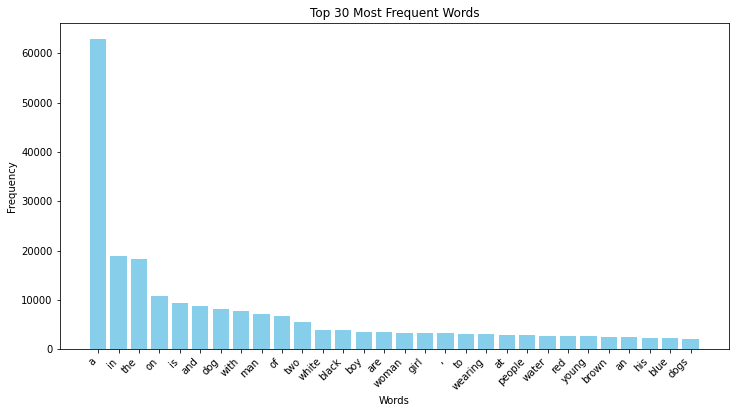

In [11]:
# visualise the top 30 occuring words in the captions

def plot_top_words(word_counts):
    words, counts = zip(*word_counts)  # Unpack words and their frequencies

    plt.figure(figsize=(12, 6))
    plt.bar(words, counts, color='skyblue')
    plt.xticks(rotation=45, ha='right')
    plt.xlabel("Words")
    plt.ylabel("Frequency")
    plt.title(f"Top 30 Most Frequent Words")
    plt.show()

print(val_count.most_common(30))
plot_top_words(val_count.most_common(30))

### 2. Data preparation

**2.1 Captions Preprocessing**

1.Create the tokenized vectors by tokenizing the captions fore ex :split them using spaces & other filters. This gives us a vocabulary of all of the unique words in the data. Keep the total vocaublary to top 5,000 words for saving memory.

2.Replace all other words with the unknown token "UNK" .

3.Create word-to-index and index-to-word mappings.

4.Pad all sequences to be the same length as the longest one.

In [12]:
# utility to process all the captions

def preprocess_captions(captions):
    result = []
    
    for caption in captions:
        caption = caption.lower() # convert to lower case
        caption = re.sub(r'[^\w\s]', '', caption) # remove puntuations
        caption = [word for word in caption.split() if len(word) > 1]
        result.append(' '.join(caption))
    
    return result

In [13]:
# create a list which contains all the captions
annotations = preprocess_captions(list(df['Captions']))

# add the <start> & <end> token to all those captions as well
annotations = ['<start> {0} <end>'.format(annot) for annot in annotations]

# create a list which contains all the path to the images
all_img_path = list(df['Path'])

print("Total captions present in the dataset: "+ str(len(annotations)))
print("Total images present in the dataset: " + str(len(all_imgs)))

Total captions present in the dataset: 40455
Total images present in the dataset: 8091


In [14]:
# view 5 captions

annotations[0:5]

['<start> child in pink dress is climbing up set of stairs in an entry way <end>',
 '<start> girl going into wooden building <end>',
 '<start> little girl climbing into wooden playhouse <end>',
 '<start> little girl climbing the stairs to her playhouse <end>',
 '<start> little girl in pink dress going into wooden cabin <end>']

In [15]:
# create the tokenizer

max_word_cnt = 6000
tokenizer = Tokenizer(num_words = max_word_cnt + 1, oov_token = 'UNK', filters= '!"#$%^&*()_+.,:;-?/~`{}[]|\=@ ')
tokenizer.fit_on_texts(annotations)

In [16]:
# add PAD token for zero

tokenizer.word_index['PAD'] = 0
tokenizer.index_word[0] = 'PAD'

In [17]:
# create word-to-index and index-to-word mappings.

word_index = tokenizer.word_index
index_word = tokenizer.index_word

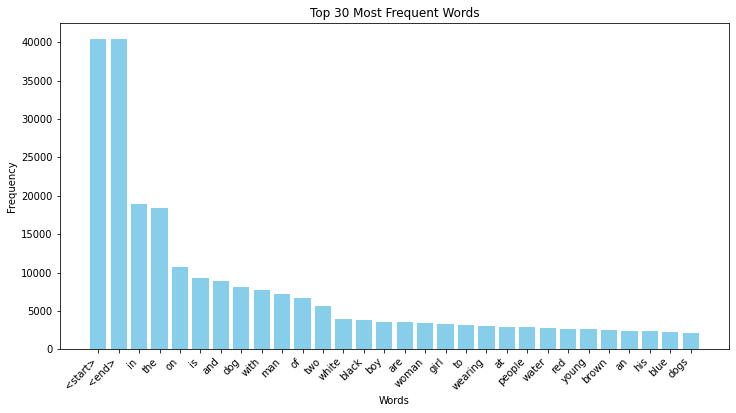

In [18]:
# create a word count of your tokenizer to visulize the Top 30 occuring words after text processing

words_count = tokenizer.word_counts
words_count = dict(sorted(words_count.items(), key = lambda x : x[1], reverse = True))
top_words = list(words_count.items())[:30]
plot_top_words(top_words)

In [19]:
# pad each vector to the max_length of the captions ^ store it to a vairable

train_sequence = tokenizer.texts_to_sequences(annotations)
train_seqs_len = [len(seq) for seq in train_sequence]
seq_max_len = max(train_seqs_len)
cap_vector = pad_sequences(train_sequence, maxlen = seq_max_len, padding = 'post')
print("The shape of Caption vector is :" + str(cap_vector.shape))

The shape of Caption vector is :(40455, 34)


**2.2 Pre-processing the images**

1.Resize them into the shape of (299, 299)

2.Normalize the image within the range of -1 to 1, such that it is in correct format for InceptionV3.

In [20]:
# utility to preprocess the image

def load_image(image_path):
    img = tf.io.read_file(image_path, name = None)
    img = tf.image.decode_jpeg(img, channels=0)
    img = tf.image.resize(img, IMG_SHAPE)
    img = tf.keras.applications.inception_v3.preprocess_input(img)
    
    return img, image_path

In [21]:
# applying the function to the image path dataset, such that the transformed dataset should contain images & their path

img_data = tf.data.Dataset.from_tensor_slices(list(set(all_img_path)))
img_data = img_data.map(load_image, num_parallel_calls = tf.data.experimental.AUTOTUNE)
img_data = img_data.batch(BATCH_SIZE, drop_remainder = False)

2025-03-16 07:24:28.597488: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:1052] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2025-03-16 07:24:28.634310: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:1052] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2025-03-16 07:24:28.634691: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:1052] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2025-03-16 07:24:28.638675: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:1052] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2025-03-16 07:24:28.639043: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:1052] successful NUMA node read f

**2.3 Load the pretrained Imagenet weights of Inception net V3**

1.To save the memory(RAM) from getting exhausted, extract the features of the images using the last layer of pre-trained model. Including this as part of training will lead to higher computational time.

2.The shape of the output of this layer is 8x8x2048.

3.Use a function to extract the features of each image in the train & test dataset such that the shape of each image should be (batch_size, 8*8, 2048)

In [22]:
image_model = tf.keras.applications.InceptionV3(include_top=False, weights='imagenet')

new_input = image_model.input
hidden_layer = image_model.layers[-1].output

#build the final model using both input & output layer
image_features_extract_model = tf.keras.Model(new_input, hidden_layer)

In [23]:
# apply the feature_extraction model to your earlier created dataset which contained images & their respective paths
# Once the features are created, you need to reshape them such that feature shape is in order of (batch_size, 8*8, 2048)

img_features = {}

for image, image_path in tqdm(img_data):
    batch_features = image_features_extract_model(image)
    batch_features_flattened = tf.reshape(batch_features, (batch_features.shape[0], -1, batch_features.shape[3]))
    
    for batch_feat, path in zip(batch_features_flattened, image_path) :
        feature_path = path.numpy().decode('utf-8')
        img_features[feature_path] = batch_feat.numpy()

  0%|          | 0/32 [00:00<?, ?it/s]2025-03-16 07:24:44.498425: I tensorflow/stream_executor/cuda/cuda_dnn.cc:377] Loaded cuDNN version 8302
2025-03-16 07:24:46.336124: I tensorflow/stream_executor/cuda/cuda_blas.cc:1792] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
100%|██████████| 32/32 [00:20<00:00,  1.56it/s]


### 3. Dataset creation

1. Apply train_test_split on both image path & captions to create the train & test list. Create the train-test spliit using 80-20 ratio & random state = 42

2. Create a function which maps the image path to their feature.

3. Create a builder function to create train & test dataset & apply the function created earlier to transform the dataset

4. Make sure you have done Shuffle and batch while building the dataset

5. The shape of each image in the dataset after building should be (batch_size, 8*8, 2048)

6. The shape of each caption in the dataset after building should be(batch_size, max_len)

In [24]:
# split into train and test

path_train, path_test, cap_train, cap_test = train_test_split(all_img_path, cap_vector, train_size=0.8, random_state=42)

In [25]:
print("Training data for images: " + str(len(path_train)))
print("Testing data for images: " + str(len(path_test)))
print("Training data for Captions: " + str(len(cap_train)))
print("Testing data for Captions: " + str(len(cap_test)))

Training data for images: 32364
Testing data for images: 8091
Training data for Captions: 32364
Testing data for Captions: 8091


In [26]:
# Create a function which maps the image path to their feature. 
# This function will take the image_path & caption and return it's feature & respective caption.

def map_func(image_path, caption):
    img_tensor = img_features[image_path.decode('utf-8')]
    return img_tensor, caption

In [27]:
# create a builder function to create dataset which takes in the image path & captions as input
# This function should transform the created dataset(img_path,cap) to (features,cap) using the map_func created earlier

BUFFER_SIZE = 1000

def generate_dataset(image_paths, captions):
    dataset = tf.data.Dataset.from_tensor_slices((image_paths, captions))
    dataset = dataset.map(lambda path, cap: tf.numpy_function(map_func, [path, cap], [tf.float32, tf.int32]), num_parallel_calls = tf.data.experimental.AUTOTUNE)
    dataset = (dataset.shuffle(BUFFER_SIZE, reshuffle_each_iteration= True).batch(BATCH_SIZE, drop_remainder = False).prefetch(tf.data.experimental.AUTOTUNE))
    return dataset

In [28]:
train_dataset = generate_dataset(path_train,cap_train)
test_dataset = generate_dataset(path_test,cap_test)

In [29]:
sample_img_batch, sample_cap_batch = next(iter(train_dataset))
print(sample_img_batch.shape)  #(batch_size, 8*8, 2048)
print(sample_cap_batch.shape) #(batch_size,max_len)

(256, 64, 2048)
(256, 34)


### 4. Model Building

1.Set the parameters

2.Build the Encoder, Attention model & Decoder

In [30]:
# set the parameters

embedding_dim = 256 
units = 512
vocab_size = 6001
train_num_steps = len(path_train) // BATCH_SIZE
test_num_steps = len(path_test) // BATCH_SIZE
max_length = seq_max_len
feature_shape = batch_feat.shape[1]
attention_feature_shape = batch_feat.shape[0]

**4.1 Encoder**

In [31]:
# define encoder

class Encoder(tf.keras.Model):
    def __init__(self, embed_dim):
        super(Encoder, self).__init__()
        
        #build your Dense layer with relu activation
        self.dense = tf.keras.layers.Dense(embed_dim, activation = 'relu')
        
    def call(self, features):
        
        # extract the features from the image shape: (batch, 8*8, embed_dim)
        features =  self.dense(features) 
        
        return features

In [32]:
encoder = Encoder(embedding_dim)

**4.2 Attention model**

In [33]:
# define attention model

class Attention_model(tf.keras.Model):
    def __init__(self, units):
        super(Attention_model, self).__init__()
        self.W1 = tf.keras.layers.Dense(units) #build your Dense layer
        self.W2 = tf.keras.layers.Dense(units) #build your Dense layer
        self.V = tf.keras.layers.Dense(1) #build your final Dense layer with unit 1
        self.units = units

    def call(self, features, hidden):
        #features shape: (batch_size, 8*8, embedding_dim)
        # hidden shape: (batch_size, hidden_size)
        
        # Expand the hidden shape to shape: (batch_size, 1, hidden_size)
        hidden_with_time_axis = tf.expand_dims(hidden, axis=1) 
        
        # build your score funciton to shape: (batch_size, 8*8, units)
        score = self.V(tf.nn.tanh(self.W1(features) + self.W2(hidden_with_time_axis))) 
        
        # extract your attention weights with shape: (batch_size, 8*8, 1)
        attention_weights =  tf.nn.softmax(score, axis=1)
        
        #shape: create the context vector with shape (batch_size, 8*8,embedding_dim)
        context_vector =  attention_weights * features
        
        # reduce the shape to (batch_size, embedding_dim)
        context_vector = tf.reduce_sum(context_vector, axis=1)
        
        return context_vector, attention_weights

**4.3 Decoder**

In [34]:
# define decoder

class Decoder(tf.keras.Model):
    def __init__(self, embed_dim, units, vocab_size):
        super(Decoder, self).__init__()
        self.units = units
        
        # iniitalise your Attention model with units
        self.attention = Attention_model(units)
        
        # build your Embedding layer
        self.embed = tf.keras.layers.Embedding(vocab_size, embed_dim)
        
        # build GRU
        self.gru = tf.keras.layers.GRU(self.units,return_sequences=True,return_state=True,recurrent_initializer='glorot_uniform')
        
        # build your Dense layers
        # self.d1 = tf.keras.layers.Dense(units, activation='relu')
        self.d1 = tf.keras.layers.Dense(units)
        self.d2 = tf.keras.layers.Dense(vocab_size)
        

    def call(self, x, features, hidden):
        # create your context vector & attention weights from attention model
        context_vector, attention_weights = self.attention(features, hidden)
        
        # embed your input to shape: (batch_size, 1, embedding_dim)
        embed = self.embed(x)
        
        # Concatenate your input with the context vector from attention layer. Shape: (batch_size, 1, embedding_dim + embedding_dim)
        embed =  tf.concat([tf.expand_dims(context_vector, 1), embed], axis=-1)
        
        # Extract the output & hidden state from GRU layer. Output shape : (batch_size, max_length, hidden_size)
        output, state = self.gru(embed, initial_state=hidden)
        # output, state = self.gru(embed)
        output = self.d1(output)
        
        output = tf.reshape(output, (-1, output.shape[2])) # shape : (batch_size * max_length, hidden_size)
        output = self.d2(output) # shape : (batch_size * max_length, vocab_size)
        
        return output, state, attention_weights
    
    def init_state(self, batch_size):
        return tf.zeros((batch_size, self.units))

In [35]:
decoder = Decoder(embedding_dim, units, vocab_size)

In [36]:
features = encoder(sample_img_batch)

hidden = decoder.init_state(batch_size=sample_cap_batch.shape[0])
dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * sample_cap_batch.shape[0], 1)

predictions, hidden_out, attention_weights = decoder(dec_input, features, hidden)
print('Feature shape from Encoder: {}'.format(features.shape)) #(batch, 8*8, embed_dim)
print('Predcitions shape from Decoder: {}'.format(predictions.shape)) #(batch, vocab_size)
print('Attention weights shape from Decoder: {}'.format(attention_weights.shape)) #(batch, 8*8, embed_dim)

Feature shape from Encoder: (256, 64, 256)
Predcitions shape from Decoder: (256, 6001)
Attention weights shape from Decoder: (256, 64, 1)


### 5. Model building and optimization

1.Set the optimizer & loss object

2.Create your checkpoint path

3.Create your training & testing step functions

4.Create your loss function for the test dataset

In [37]:
optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0005) #define the optimizer
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True, reduction = tf.keras.losses.Reduction.NONE) #define your loss object

In [38]:
def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)
    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_mean(loss_)

* While creating the training step for your model, you will apply Teacher forcing.
* Teacher forcing is a technique where the target/real word is passed as the next input to the decoder instead of previous prediciton.

In [39]:
@tf.function
def train_step(img_tensor, target):
    loss = 0
    hidden = decoder.init_state(batch_size=target.shape[0])
    dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * target.shape[0], 1)
    
    with tf.GradientTape() as tape:
        #write your code here to do the training steps
        enc_output = encoder(img_tensor, training =True)
        
        for i in range(1, target.shape[1]):
            pred, hidden, _ = decoder(dec_input, enc_output, hidden)
            loss += loss_function(target[:, i], pred)
            dec_input = tf.expand_dims(target[:, i], axis=1)
        
    trainable_vars = encoder.trainable_variables + decoder.trainable_variables
    grad = tape.gradient(loss, trainable_vars)
    optimizer.apply_gradients(zip(grad, trainable_vars))
    avg_loss = (loss/ int(target.shape[1]))
    
    return loss, avg_loss

* While creating the test step for your model, you will pass your previous prediciton as the next input to the decoder.

In [40]:
@tf.function
def test_step(img_tensor, target):
    loss = 0
    hidden = decoder.init_state(batch_size=target.shape[0])
    dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * target.shape[0], 1)
    enc_output = encoder(img_tensor, training = False)
    
    for i in range(1, target.shape[1]):
        pred, hidden, _ = decoder(dec_input, enc_output, hidden)
        loss += loss_function(target[:, i], pred)
        predicted_id = tf.argmax(pred[0])
        dec_input = tf.expand_dims([predicted_id] * target.shape[0] , axis=1)
        
    avg_loss = (loss / int(target.shape[1]))
    
    return loss, avg_loss

In [41]:
def test_loss_cal(test_dataset):
    total_loss = 0
    
    for img_tensor, target in test_dataset:
        loss, avg_loss = test_step(img_tensor, target)
        total_loss += avg_loss
    
    avg_test_loss = total_loss / int(test_num_steps)
    
    return avg_test_loss

In [42]:
loss_plot = []
test_loss_plot = []
EPOCHS = 15

best_test_loss=100
for epoch in tqdm(range(0, EPOCHS)):
    start = time.time()
    total_loss = 0

    for (batch, (img_tensor, target)) in enumerate(train_dataset):
        batch_loss, t_loss = train_step(img_tensor, target)
        total_loss += t_loss
    
    avg_train_loss=total_loss / train_num_steps
        
    loss_plot.append(avg_train_loss)    
    test_loss = test_loss_cal(test_dataset)
    test_loss_plot.append(test_loss)
    
    print ('For epoch: {}, the train loss is {:.3f}, & test loss is {:.3f}'.format(epoch+1,avg_train_loss,test_loss))
    print ('Time taken for 1 epoch {} sec\n'.format(time.time() - start))
    
    if test_loss < best_test_loss:
        print('Test loss has been reduced from %.3f to %.3f' % (best_test_loss, test_loss))
        best_test_loss = test_loss

  7%|▋         | 1/15 [01:18<18:21, 78.68s/it]

For epoch: 1, the train loss is 1.678, & test loss is 1.685
Time taken for 1 epoch 78.6753237247467 sec

Test loss has been reduced from 100.000 to 1.685


 13%|█▎        | 2/15 [01:36<09:14, 42.62s/it]

For epoch: 2, the train loss is 1.333, & test loss is 2.024
Time taken for 1 epoch 17.38044548034668 sec



 20%|██        | 3/15 [01:53<06:13, 31.14s/it]

For epoch: 3, the train loss is 1.167, & test loss is 2.101
Time taken for 1 epoch 17.483110189437866 sec



 27%|██▋       | 4/15 [02:11<04:44, 25.83s/it]

For epoch: 4, the train loss is 1.075, & test loss is 2.151
Time taken for 1 epoch 17.682735443115234 sec



 33%|███▎      | 5/15 [02:28<03:48, 22.84s/it]

For epoch: 5, the train loss is 1.004, & test loss is 2.211
Time taken for 1 epoch 17.54515838623047 sec



 40%|████      | 6/15 [02:46<03:09, 21.10s/it]

For epoch: 6, the train loss is 0.947, & test loss is 2.178
Time taken for 1 epoch 17.703291177749634 sec



 47%|████▋     | 7/15 [03:04<02:39, 20.00s/it]

For epoch: 7, the train loss is 0.898, & test loss is 2.233
Time taken for 1 epoch 17.736236572265625 sec



 53%|█████▎    | 8/15 [03:21<02:15, 19.29s/it]

For epoch: 8, the train loss is 0.854, & test loss is 2.299
Time taken for 1 epoch 17.77885603904724 sec



 60%|██████    | 9/15 [03:39<01:52, 18.68s/it]

For epoch: 9, the train loss is 0.813, & test loss is 2.251
Time taken for 1 epoch 17.338595867156982 sec



 67%|██████▋   | 10/15 [03:56<01:31, 18.26s/it]

For epoch: 10, the train loss is 0.776, & test loss is 2.331
Time taken for 1 epoch 17.31766438484192 sec



 73%|███████▎  | 11/15 [04:14<01:12, 18.02s/it]

For epoch: 11, the train loss is 0.741, & test loss is 2.354
Time taken for 1 epoch 17.46587586402893 sec



 80%|████████  | 12/15 [04:31<00:53, 17.85s/it]

For epoch: 12, the train loss is 0.706, & test loss is 2.377
Time taken for 1 epoch 17.47545075416565 sec



 87%|████████▋ | 13/15 [04:48<00:35, 17.66s/it]

For epoch: 13, the train loss is 0.674, & test loss is 2.412
Time taken for 1 epoch 17.225489377975464 sec



 93%|█████████▎| 14/15 [05:06<00:17, 17.66s/it]

For epoch: 14, the train loss is 0.643, & test loss is 2.450
Time taken for 1 epoch 17.637842655181885 sec



100%|██████████| 15/15 [05:24<00:00, 21.61s/it]

For epoch: 15, the train loss is 0.612, & test loss is 2.483
Time taken for 1 epoch 17.660550832748413 sec



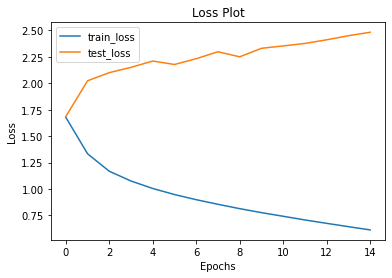

In [43]:
# plot train and test loss

plt.plot(loss_plot)
plt.plot(test_loss_plot)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Plot')
plt.legend(['train_loss', 'test_loss'])
plt.show()

**NOTE:**

* Since there is a difference between the train & test steps ( Presence of teacher forcing), you may observe that the train loss is decreasing while your test loss is not.
* This doesn't mean that the model is overfitting, as we can't compare the train & test results here, as both approach is different.
* Also, if you want to achieve better results you can run it more epochs, but the intent of this capstone is to give you an idea on how to integrate attention mechanism with E-D architecture for images. The intent is not to create the state of art model.

### 6. Model evaluation

1.Define your evaluation function using greedy search

2.Define your evaluation function using beam search ( optional)

3.Test it on a sample data using BLEU score

**Greedy search**

In [44]:
# utility for greedy search

def greedy_evaluate(image_path):
    attention_plot = np.zeros((max_length, attention_feature_shape))
    hidden = decoder.init_state(batch_size=1)
    
    temp_input = tf.expand_dims(load_image(image_path)[0], 0) #process the input image to desired format before extracting features
    img_tensor_val = image_features_extract_model(temp_input) # Extract features using our feature extraction model
    img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0], -1, img_tensor_val.shape[3]))
    
    features = encoder(img_tensor_val) # extract the features by passing the input to encoder

    dec_input = tf.expand_dims([tokenizer.word_index['<start>']], 0)
    result = []

    for i in range(max_length):
        predictions, hidden, attention_weights = decoder(dec_input, features, hidden) # get the output from decoder

        attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()

        predicted_id = tf.argmax(predictions, axis=-1) #extract the predicted id(embedded value) which carries the max value
        predicted_id = predicted_id.numpy()[0]
        result.append(index_word[predicted_id]) #map the id to the word from tokenizer and append the value to the result list

        if tokenizer.index_word[predicted_id] == '<end>':
            return result, attention_plot, predictions

        dec_input = tf.expand_dims([predicted_id], 0)

    attention_plot = attention_plot[:len(result), :]
    
    return result, attention_plot, predictions

In [45]:
from PIL import Image

def plot_attmap(caption, weights, image):

    fig = plt.figure(figsize=(40, 40))
    temp_img = np.array(Image.open(image))
    
    len_cap = len(caption)
    for cap in range(len_cap):
        weights_img = np.reshape(weights[cap], (8,8))
        weights_img = np.array(Image.fromarray(weights_img).resize((224, 224), Image.LANCZOS))
        
        ax = fig.add_subplot(len_cap//2, len_cap//2, cap+1)
        ax.set_title(caption[cap], fontsize=15)
        
        img=ax.imshow(temp_img)
        
        ax.imshow(weights_img, cmap='gist_heat', alpha=0.6,extent=img.get_extent())
        ax.axis('off')
    plt.subplots_adjust(hspace=0.2, wspace=0.2)
    plt.show()

In [46]:
def filt_text(text):
    filt=['<start>','<unk>','<end>'] 
    temp= text.split()
    [temp.remove(j) for k in filt for j in temp if k==j]
    text=' '.join(temp)
    return text

### 7. Predictions on unseen data

BELU score: 45.78227398676668
Real Caption: two girls are standing by another family in front of wooden barn
Predicted Caption: adults and children are standing in front of barn


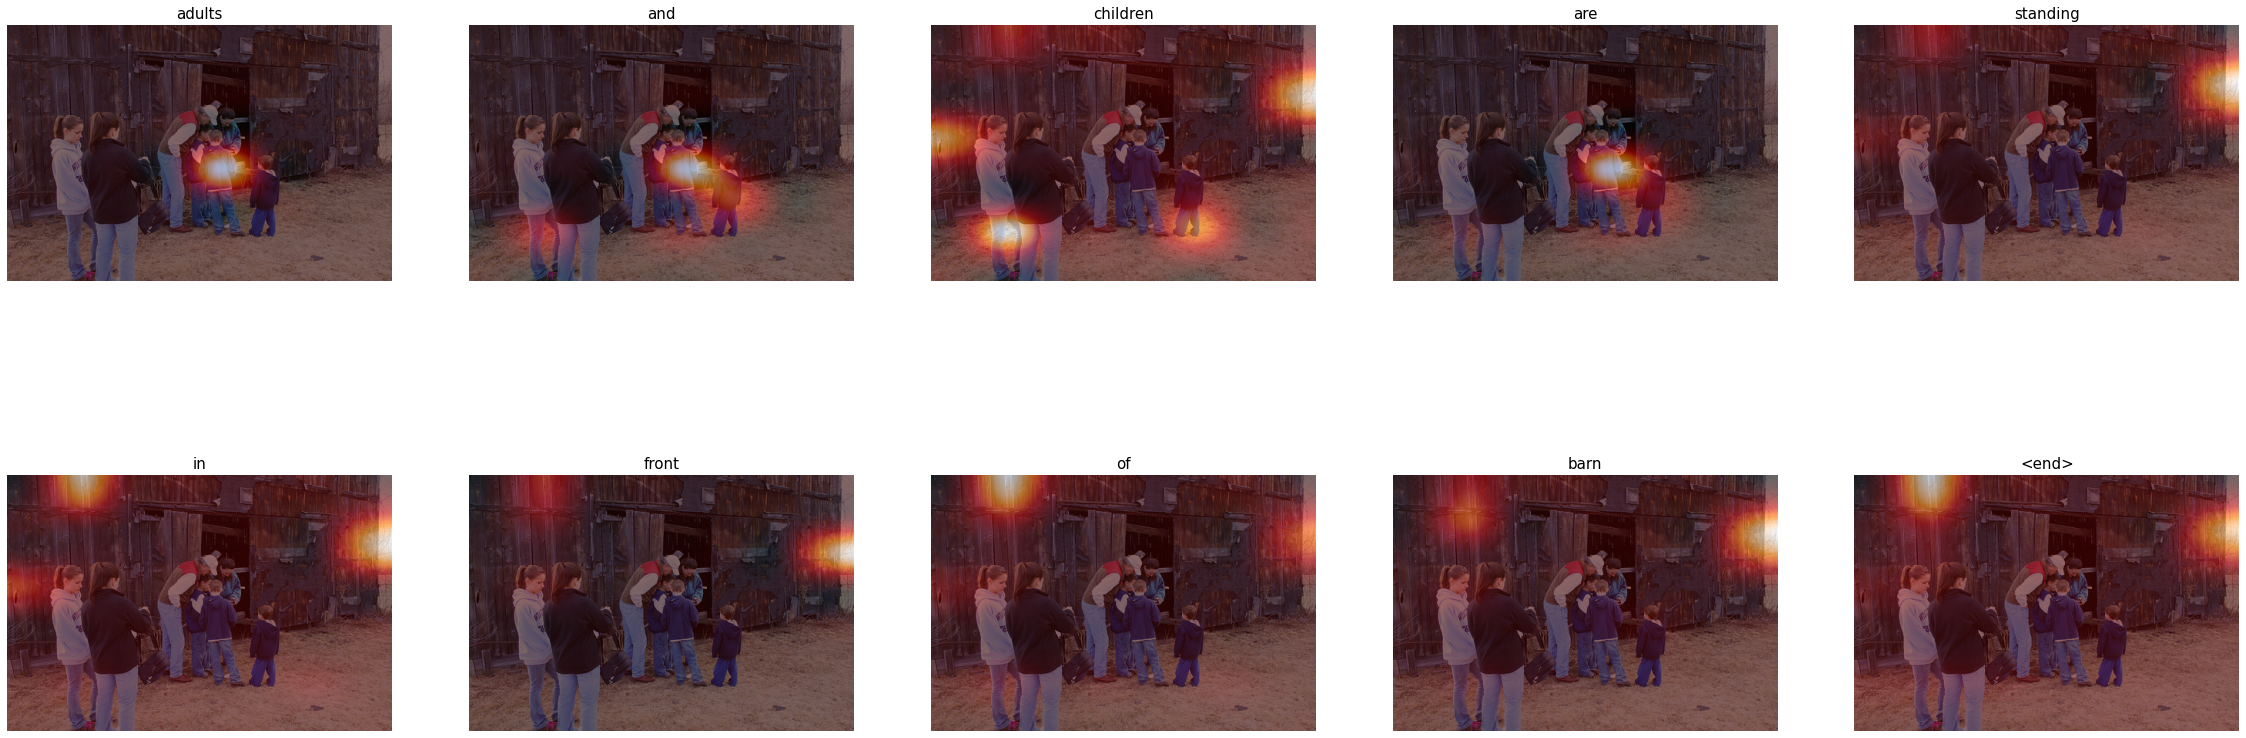

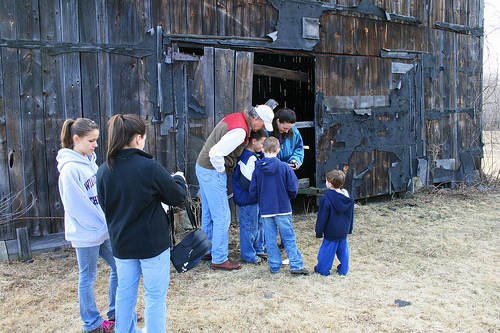

In [56]:
# predictions on unseen data

rid = np.random.randint(0, len(path_test))
test_image = path_test[rid]
real_caption = ' '.join([tokenizer.index_word[i] for i in cap_test[rid] if i not in [0]])

result, attention_plot, pred_test = greedy_evaluate(test_image)
real_caption=filt_text(real_caption)      
pred_caption=' '.join(result).rsplit(' ', 1)[0]

real_appn = []
real_appn.append(real_caption.split())
reference = real_appn
candidate = pred_caption.split()

score = sentence_bleu(reference, candidate, weights = (0.5, 0.25, 0, 0))
print(f"BELU score: {score*100}")


print ('Real Caption:', real_caption)
print ('Predicted Caption:', pred_caption)
plot_attmap(result, attention_plot, test_image)

Image.open(test_image)

### 8. Convert to speech

* gTTS (Google text to speech) library is used for conversion.

In [57]:
# Text to be converted to speech
text = 'Predicted Caption : ' + pred_caption

# Convert text to speech
tts = gTTS(text=text, lang='en', slow=False)

# Save the speech audio file
tts.save("output.mp3")

# # Play the saved audio file
display.display(display.Audio("output.mp3", rate = None, autoplay = True))